# 0. About

This notebook is to explore regularized CCA.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import warnings
import time

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import CCA, PLSCanonical
from sklearn.utils import Bunch
from sklearn.metrics.pairwise import cosine_similarity

from cca_zoo.models import CCA as cz_CCA
from cca_zoo.models import rCCA as cz_rCCA
from cca_zoo.model_selection import GridSearchCV as cz_GridSearchCV
from cca_zoo.plotting import pairplot_train_test

rs_num = 14
rng = np.random.default_rng(rs_num)

sklearn.set_config(display="diagram")

n_splits = 5
n_repeats = 50

%matplotlib inline

# 1. Dataset Construction

In [2]:
sample_num = 75
X_dimension_num = 70
Y_dimension_num = 10

# construct X
X = rng.normal(loc=0.0, scale=1.0, size=(sample_num, X_dimension_num))

# noise
xi_1 = rng.normal(loc=0, scale=np.sqrt(0.2), size=(sample_num, ))
xi_2 = rng.normal(loc=0, scale=np.sqrt(0.4), size=(sample_num, ))
xi_3 = rng.normal(loc=0, scale=np.sqrt(0.3), size=(sample_num, ))

# contruct Y
Y = rng.normal(loc=0.0, scale=1.0, size=(sample_num, Y_dimension_num))
Y[:, 0] = X[:, 2] + xi_1
Y[:, 1] = X[:, 0] + xi_2
Y[:, 2] = -X[:, 3] + xi_3

# split them into training and test dataset
[X_train, X_test, Y_train, Y_test] = train_test_split(
    X, Y, test_size=0.20, random_state=rs_num
)

# 2. CCA

In [3]:
cca_bunch = Bunch()
cca_bunch.name = 'cca'

cca_bunch.n_components = np.min([X_dimension_num, Y_dimension_num])

# fit cca
cca_bunch.cca = cz_CCA(
    latent_dims=cca_bunch.n_components, 
    random_state=rs_num
).fit((X_train, Y_train))

# transform datasets
[cca_bunch.Xc_train, 
 cca_bunch.Yc_train] = cca_bunch.cca.transform((X_train, Y_train))
[cca_bunch.Xc_test, 
 cca_bunch.Yc_test] = cca_bunch.cca.transform((X_test, Y_test))

# obtain canonical correlations
print('CC over training dataset: ', cca_bunch.cca.score((X_train, Y_train)))
print('CC over test dataset: ', cca_bunch.cca.score((X_test, Y_test)))

CC over training dataset:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
CC over test dataset:  [-0.14024401  0.25459742  0.00256951  0.41592166  0.31901487 -0.05798239
  0.08515362  0.05595471  0.07752314  0.06764906]


# 3. Regularized CCA

In [4]:
# we need to define the scoring method with customized scoring function
# ref: https://github.com/jameschapman19/cca_zoo/issues/150
def scoring_func(estimator, views):
    return np.nanmean(estimator.score(views))

In [5]:
rcca_bunch = Bunch()
rcca_bunch.name = 'rcca'

rcca_bunch.n_components = np.min([X_dimension_num, Y_dimension_num])

rcca_bunch.rkf = RepeatedKFold(
    n_splits=n_splits, n_repeats=n_repeats, random_state=rs_num
)

## 3.1. Grid Search for Optimal Regularization Parameters

In [6]:
# set up grids
rcca_bunch.c1_list = [0.95*i for i in np.logspace(-3, 1, 21)] # regularization parameter
rcca_bunch.c2_list = [0.95*i for i in np.logspace(-3, 1, 21)] # regularization parameter

rcca_bunch.param_grid = {
    'c': [rcca_bunch.c1_list, rcca_bunch.c2_list]
}

In [7]:
# starting of the track of computing time
t_start = time.time()

# ignore warnings for some bad searching
warnings.filterwarnings('ignore')

# searching for best parameters
rcca_bunch.gscv_results = cz_GridSearchCV(
    cz_rCCA(
        latent_dims=rcca_bunch.n_components, 
        random_state=rs_num
    ), 
    param_grid=rcca_bunch.param_grid, 
    scoring=scoring_func, 
    cv=rcca_bunch.rkf
).fit([X_train, Y_train])

# reset warnings
warnings.resetwarnings()

# ending of the track of computing time
t_elapsed = time.time() - t_start

In [8]:
print('Above cell computation takes {:.1f} seconds.'.format(t_elapsed))

Above cell computation takes 494.9 seconds.


In [9]:
# rearrange parameter grid
param_grid_c1_arr_viz = np.zeros_like(
    rcca_bunch.gscv_results.cv_results_['param_estimator__c'].data
)
param_grid_c2_arr_viz = np.zeros_like(param_grid_c1_arr_viz)

for param_i, param_list in enumerate(
    rcca_bunch.gscv_results.cv_results_['param_estimator__c'].data
):
    param_grid_c1_arr_viz[param_i] = param_list[0]
    param_grid_c2_arr_viz[param_i] = param_list[1]

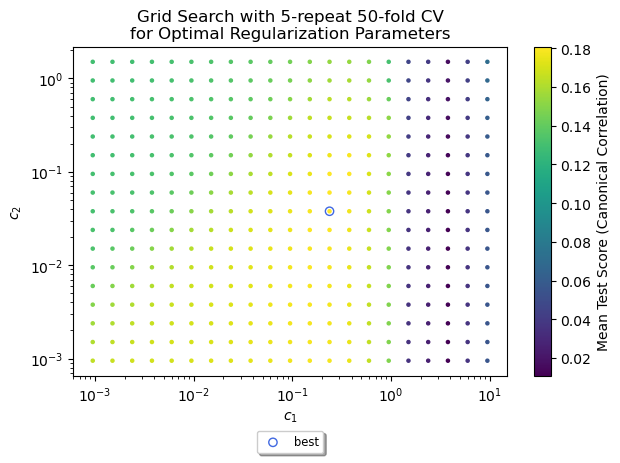

In [10]:
fig, ax = plt.subplots()

sc = ax.scatter(
    param_grid_c1_arr_viz, 
    param_grid_c2_arr_viz, 
    c=rcca_bunch.gscv_results.cv_results_['mean_test_score'], 
    s=5
)
cbar = plt.colorbar(sc)
cbar.set_label('Mean Test Score (Canonical Correlation)')
ax.scatter(
    rcca_bunch.gscv_results.best_params_['c'][0], 
    rcca_bunch.gscv_results.best_params_['c'][1], 
    marker='o',
    ec='royalblue', 
    fc='none', 
    label='best'
)

ax.set(
    xscale='log', 
    yscale='log', 
    xlabel='$c_1$', 
    ylabel='$c_2$', 
    title=(
        'Grid Search with {}-repeat {}-fold CV'.format(n_splits, n_repeats) + 
        '\nfor Optimal Regularization Parameters'
    )
)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    ncol=1,
    fontsize='small'
)

plt.tight_layout()

## 3.2. Check out Optimal Parameters

In [11]:
print('For regularized CCA:')

# fit cca
rcca_bunch.cca = rcca_bunch.gscv_results.best_estimator_
rcca_bunch.cca.fit((X_train, Y_train))

# transform datasets
[rcca_bunch.Xc_train, 
 rcca_bunch.Yc_train] = rcca_bunch.cca.transform((X_train, Y_train))
[rcca_bunch.Xc_test, 
 rcca_bunch.Yc_test] = rcca_bunch.cca.transform((X_test, Y_test))

# obtain canonical correlations
rcca_bunch.cc_train = rcca_bunch.cca.score((X_train, Y_train))
rcca_bunch.cc_test = rcca_bunch.cca.score((X_test, Y_test))
print('  CC over training dataset: ', rcca_bunch.cc_train)
print('  CC over test dataset: ', rcca_bunch.cc_test)

For regularized CCA:
  CC over training dataset:  [0.98442185 0.9809168  0.98273143 0.97685211 0.97076337 0.94315721
 0.91943712 0.89967651 0.88972284 0.88443016]
  CC over test dataset:  [ 0.68936571  0.50439492  0.20759669  0.3704354   0.22297629  0.3019718
 -0.31217631 -0.30802812  0.24105803  0.29899811]


In [12]:
# obtain weights
rcca_bunch.wx, rcca_bunch.wy = rcca_bunch.cca.weights

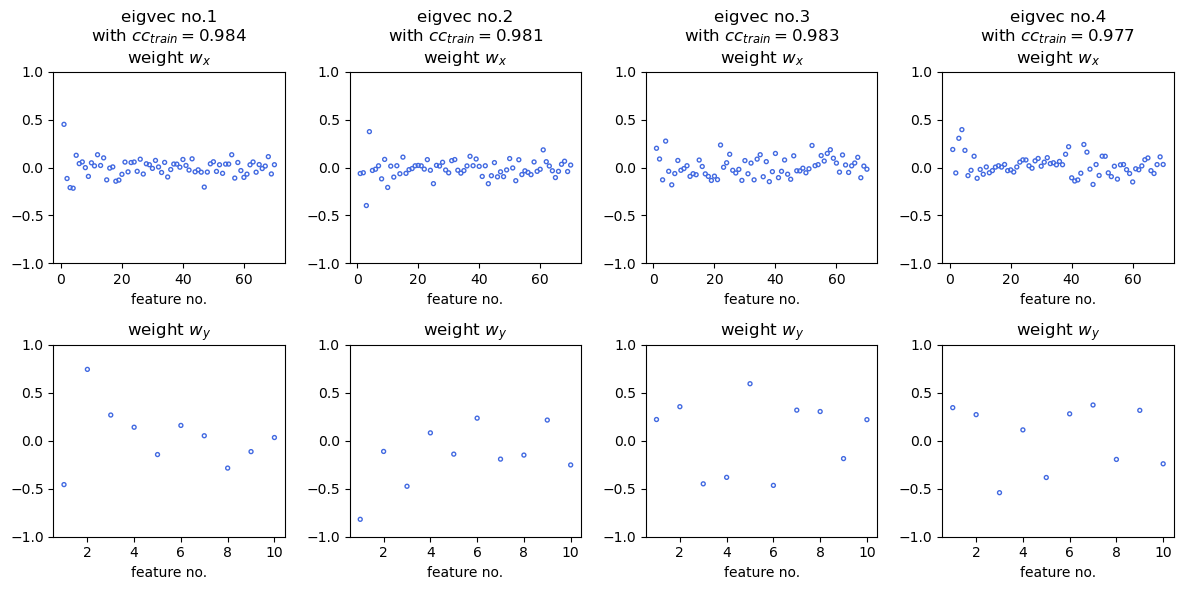

In [13]:
# viz parameters
marker_color='royalblue'
marker_sz = 8
eig_viz_num = 4 # eigenvector number to visualize

fig, axes = plt.subplots(2, eig_viz_num, figsize=(eig_viz_num*3, 6))

# w_x
for wx_i in range(eig_viz_num):
    axes[0, wx_i].scatter(
        np.arange(1, X_dimension_num+1), rcca_bunch.wx[:, wx_i], 
        fc='none', ec=marker_color, s=marker_sz
    )
    axes[0, wx_i].set(
        title=(
            'eigvec no.{}\n'.format(wx_i+1) +
            'with $cc_{train}=$' + 
            '{:.3f}'.format(rcca_bunch.cc_train[wx_i]) + 
            '\nweight $w_x$'
        ), 
        ylim=[-1.0, 1.0], 
        xlabel='feature no.'
    )

# w_y
for wy_i in range(eig_viz_num):
    axes[1, wy_i].scatter(
        np.arange(1, Y_dimension_num+1), rcca_bunch.wy[:, wy_i], 
        fc='none', ec=marker_color, s=marker_sz
    )
    axes[1, wy_i].set(
        title='weight $w_y$', 
        ylim=[-1.0, 1.0], 
        xlabel='feature no.'
    )

plt.tight_layout()

In [14]:
for i in range(eig_viz_num):
    print('For eigenvector No.{}'.format(i+1))
    print('  Maximum of ABS in X weights is at feature No.{}'.format(np.argmax(np.abs(rcca_bunch.wx[:, i]))+1))
    print('  Maximum of ABS in Y weights is at feature No.{}'.format(np.argmax(np.abs(rcca_bunch.wy[:, i]))+1))

For eigenvector No.1
  Maximum of ABS in X weights is at feature No.1
  Maximum of ABS in Y weights is at feature No.2
For eigenvector No.2
  Maximum of ABS in X weights is at feature No.3
  Maximum of ABS in Y weights is at feature No.1
For eigenvector No.3
  Maximum of ABS in X weights is at feature No.4
  Maximum of ABS in Y weights is at feature No.5
For eigenvector No.4
  Maximum of ABS in X weights is at feature No.4
  Maximum of ABS in Y weights is at feature No.3
